# Day 12 Analysis

Day 12 is a continuation of the analysis done on Day 11. Yesterday I took data from 1999-2021, aggregated it at the player-season level through Week 8, and compared player performances against the 2022 season through Week 8. I wanted to see if any 2022 performances compared to historically good season fast or slow starts.

Today I want to compare a player's first 8 games to their rest of season fantasy performance, to get a sense of how likely it is for a player to keep up an over or under performance. Does "regression to the mean" hold true over a season or is it more for a player's career?

## Set Up

In [304]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import dataframe_image as dfi

# Create database connection
conn = sqlite3.connect('../data/db/database.db')

In [305]:
# Useful Functions
def generate_summary(df, first_sort, secondary_sort, num_rows=10, ascending=True):

    """
    Generate a summary table sorted first by a column to set the index and then by a column to order the table.
    """

    if ascending == True:

        summary = df.sort_values(first_sort, ascending=False).reset_index(drop=True) # index = fantasy points ranking
        summary.index = summary.index + 1 # easier to read (1 is now top player by avg fantasy points)

        summary = summary.sort_values(secondary_sort, ascending=True)

        # print(summary.shape)
    
        return summary.head(num_rows).round(3).drop('player_id', axis=1)
    
    elif ascending == False:
        
        summary = df.sort_values(first_sort, ascending=False).reset_index(drop=True) # index = fantasy points ranking
        summary.index = summary.index + 1 # easier to read (1 is now top player by avg fantasy points)

        summary = summary.sort_values(secondary_sort, ascending=False)

        # print(summary.shape)
    
        return summary.head(num_rows).round(3).drop('player_id', axis=1)

## Target Share vs. PPR Fantasy Points: 1999-2021
For the analysis I will need to get the data at the player-season level where each season is split into the first 8 weeks and then the rest of the season. Seasons 1999-2020 were 16 weeks so a max of 8 games for each player per half. The 2021 consisted of 17 weeks so the second half of that season will be an average over a maximum of 9 games.

I'll compare distributions and summary stats to make sure each are similar. They should be since we've established at this point the strong relationship between target share and fantasy production. I'll run a regression on the entire dataset and then generate expected fantasy points, difference between expected points and actual points, find the hot and slow starters, and then see if they ended up regressing to the mean or expectation given their target share.

### Get Data

In [306]:
query = """
WITH first_half AS (
    SELECT
        player_id,
        season,
        "Weeks 1-8" AS half,
        player_display_name AS player_name,
        target_share AS tgt_share,
        fantasy_points_ppr AS pts_ppr
    FROM weekly 
    WHERE position = 'WR'
        AND season_type = 'REG'
        AND target_share IS NOT NULL -- There are data errors where target share was recorded as NULL, these can be removed
        AND season <> 2022
        AND week <= 8
), second_half AS (
    SELECT
        player_id,
        season,
        "Weeks 9+" AS half,
        player_display_name AS player_name,
        target_share AS tgt_share,
        fantasy_points_ppr AS pts_ppr
    FROM weekly 
    WHERE position = 'WR'
        AND season_type = 'REG'
        AND target_share IS NOT NULL -- There are data errors where target share was recorded as NULL, these can be removed
        AND season <> 2022
        AND week > 8
), aggregation_first_half AS (
    SELECT
        player_id,
        player_name,
        season,
        half,
        COUNT(*) AS num_games,
        AVG(tgt_share) AS avg_tgt_share,
        AVG(pts_ppr) AS avg_pts_ppr
    FROM first_half
    GROUP BY player_id, player_name, season, half
    HAVING COUNT(*) > 1 -- Remove players with only 1 game played (not enough data)
), aggregation_second_half AS (
    SELECT
        player_id,
        player_name,
        season,
        half,
        COUNT(*) AS num_games,
        AVG(tgt_share) AS avg_tgt_share,
        AVG(pts_ppr) AS avg_pts_ppr
    FROM second_half
    GROUP BY player_id, player_name, season, half
    HAVING COUNT(*) > 1 -- Remove players with only 1 game played (not enough data)
)
SELECT *
FROM aggregation_first_half
UNION ALL
SELECT *
FROM aggregation_second_half
"""

df_1999_2021 = pd.read_sql(query, conn)
print(df_1999_2021.shape)
df_1999_2021.head()


(6896, 7)


,player_id,player_name,season,half,num_games,avg_tgt_share,avg_pts_ppr
0,00-0000145,Derrick Alexander,1999,Weeks 1-8,7,0.225406,11.600000
1,00-0000145,Derrick Alexander,2000,Weeks 1-8,6,0.273746,17.783333
2,00-0000145,Derrick Alexander,2001,Weeks 1-8,5,0.201595,7.700000
3,00-0000145,Derrick Alexander,2002,Weeks 1-8,7,0.130659,4.771429
4,00-0000387,Reidel Anthony,1999,Weeks 1-8,6,0.187041,7.966667


### Exploratory Analysis

In [307]:
df_1999_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6896 entries, 0 to 6895
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   player_id      6896 non-null   object 
 1   player_name    6896 non-null   object 
 2   season         6896 non-null   int64  
 3   half           6896 non-null   object 
 4   num_games      6896 non-null   int64  
 5   avg_tgt_share  6896 non-null   float64
 6   avg_pts_ppr    6896 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 377.2+ KB


In [308]:
df_1999_2021.groupby('half')[['avg_tgt_share']].describe().round(4)

avg_tgt_share                                                  \
                  count    mean     std     min     25%     50%     75%   
half                                                                      
Weeks 1-8        3402.0  0.1500  0.0777  0.0199  0.0863  0.1404  0.2070   
Weeks 9+         3494.0  0.1486  0.0776  0.0198  0.0837  0.1407  0.2044   

                   
              max  
half               
Weeks 1-8  0.4039  
Weeks 9+   0.4215

In [309]:
df_1999_2021.groupby('half')[['avg_pts_ppr']].describe().round(4)

avg_pts_ppr                                                       
                count    mean     std   min     25%     50%      75%     max
half                                                                        
Weeks 1-8      3402.0  8.3251  5.2380 -0.35  4.2042  7.4500  11.7000  28.100
Weeks 9+       3494.0  8.0213  5.1373  0.00  3.9500  7.0613  11.3321  30.725

Basic summary statistics between the two halves are similar.

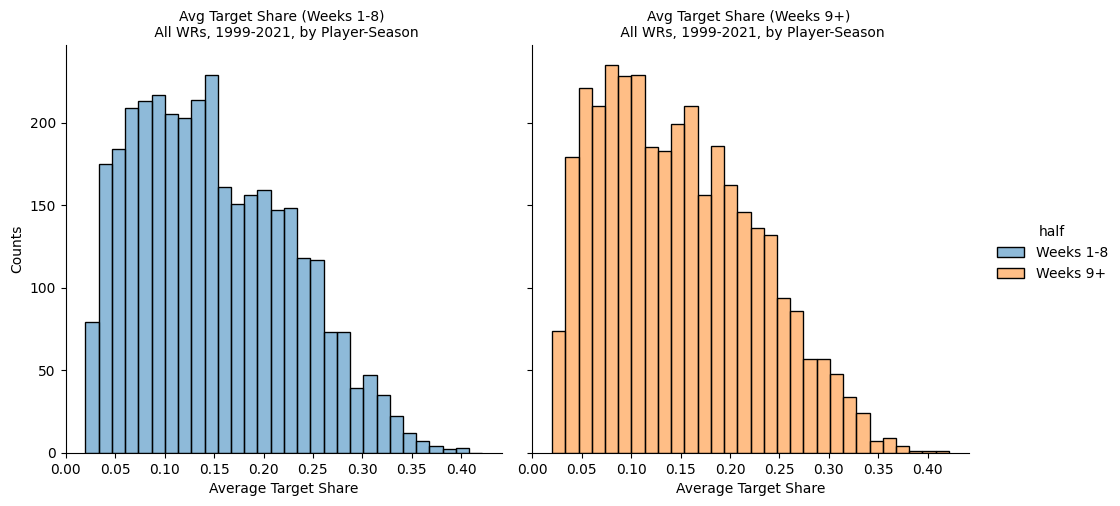

In [310]:
# Check distribution
g = sns.displot(
    x="avg_tgt_share",
    data=df_1999_2021,
    kind="hist",
    bins = 30,
    col='half',
    hue='half'
)

g.set_titles("Avg Target Share ({col_name}) \n All WRs, 1999-2021, by Player-Season")

g.set(
    xlabel="Average Target Share", 
    ylabel="Counts",
)

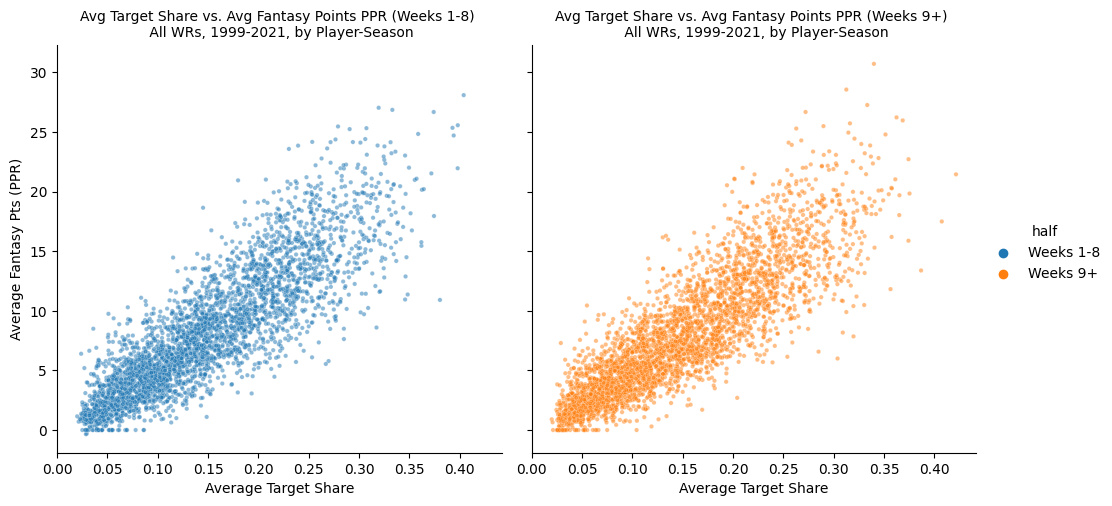

In [311]:
g = sns.relplot(
    x="avg_tgt_share",
    y="avg_pts_ppr",
    data=df_1999_2021,
    alpha=0.5,
    s=10,
    col='half',
    hue='half'
)

g.set_titles("Avg Target Share vs. Avg Fantasy Points PPR ({col_name}) \n All WRs, 1999-2021, by Player-Season")

g.set(
    xlabel="Average Target Share", 
    ylabel="Average Fantasy Pts (PPR)",
)

## Can overperformers keep it up?

In [312]:
# Fit a regression line
fit = np.polyfit(
    x=df_1999_2021['avg_tgt_share'], 
    y=df_1999_2021['avg_pts_ppr'], 
    deg=1)

lin_func_fpts = np.poly1d(fit)

df_1999_2021['avg_pts_expected'] = lin_func_fpts(df_1999_2021['avg_tgt_share'])
df_1999_2021['avg_pts_diff'] = df_1999_2021['avg_pts_ppr'] - df_1999_2021['avg_pts_expected']

In [313]:
# Top 10 by avg_pts_dff (Overperformers Weeks 1-8)
generate_summary(df_1999_2021[df_1999_2021['half'] == 'Weeks 1-8'], 'avg_pts_ppr', 'avg_pts_diff', ascending=False)

,player_name,season,half,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
55,Will Fuller,2017,Weeks 1-8,4,0.180,20.950,9.931,11.019
23,Isaac Bruce,2000,Weeks 1-8,7,0.230,23.586,12.844,10.742
146,Martavis Bryant,2014,Weeks 1-8,2,0.145,18.650,7.924,10.726
20,Randy Moss,2007,Weeks 1-8,8,0.239,23.863,13.370,10.492
14,Calvin Johnson,2011,Weeks 1-8,8,0.253,24.175,14.181,9.994
6,Torry Holt,2003,Weeks 1-8,7,0.279,25.471,15.660,9.812
53,Austin Collie,2010,Weeks 1-8,6,0.207,21.017,11.525,9.492
2,Davante Adams,2020,Weeks 1-8,5,0.319,27.040,17.989,9.051
16,Calvin Johnson,2013,Weeks 1-8,7,0.272,24.157,15.233,8.924
9,Adam Thielen,2018,Weeks 1-8,8,0.291,25.250,16.327,8.923


In [314]:
# Top 10 by avg_pts_dff (Overperformers Weeks 9+)
generate_summary(df_1999_2021[df_1999_2021['half'] == 'Weeks 9+'], 'avg_pts_ppr', 'avg_pts_diff', ascending=False)

,player_name,season,half,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
1,Antonio Brown,2015,Weeks 9+,8,0.340,30.725,19.171,11.554
4,Tyreek Hill,2020,Weeks 9+,7,0.272,26.686,15.255,11.431
2,Odell Beckham,2014,Weeks 9+,9,0.313,28.567,17.588,10.978
9,Antonio Brown,2017,Weeks 9+,6,0.263,25.300,14.720,10.580
36,Dez Bryant,2012,Weeks 9+,9,0.210,21.989,11.648,10.341
46,Jordy Nelson,2011,Weeks 9+,9,0.201,21.089,11.168,9.920
47,Ronald Curry,2004,Weeks 9+,4,0.202,21.050,11.190,9.860
14,Drew Bennett,2004,Weeks 9+,8,0.255,24.112,14.283,9.830
62,Deebo Samuel,2021,Weeks 9+,9,0.194,20.540,10.751,9.789
16,Doug Baldwin,2015,Weeks 9+,8,0.258,23.925,14.465,9.460


In [315]:
both_halves = pd.concat([
    generate_summary(df_1999_2021[df_1999_2021['half'] == 'Weeks 1-8'], 'avg_pts_ppr', 'avg_pts_diff', 10, ascending=False),
    generate_summary(df_1999_2021[df_1999_2021['half'] == 'Weeks 9+'], 'avg_pts_ppr', 'avg_pts_diff', 10, ascending=False)
])
both_halves[both_halves.duplicated(['player_name', 'season'], keep=False)] \
    .sort_values(['player_name', 'season', 'half'])

,player_name,season,half,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff


No player was in the top 10 for hottest starts of the season AND in the top 10 for hottest second halves. 

In [316]:
both_halves = pd.concat([
    generate_summary(df_1999_2021[df_1999_2021['half'] == 'Weeks 1-8'], 'avg_pts_ppr', 'avg_pts_diff', 50, ascending=False),
    generate_summary(df_1999_2021[df_1999_2021['half'] == 'Weeks 9+'], 'avg_pts_ppr', 'avg_pts_diff', 50, ascending=False)
])
both_halves[both_halves.duplicated(['player_name', 'season'], keep=False)] \
    .sort_values(['player_name', 'season', 'half'])

,player_name,season,half,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
14,Calvin Johnson,2011,Weeks 1-8,8,0.253,24.175,14.181,9.994
55,Calvin Johnson,2011,Weeks 9+,8,0.219,20.725,12.220,8.505
3,Cooper Kupp,2021,Weeks 1-8,8,0.333,26.862,18.773,8.090
10,Cooper Kupp,2021,Weeks 9+,9,0.315,24.956,17.708,7.248
129,Demaryius Thomas,2013,Weeks 1-8,8,0.209,19.062,11.617,7.445
54,Demaryius Thomas,2013,Weeks 9+,8,0.219,20.812,12.210,8.602
297,Greg Jennings,2007,Weeks 1-8,5,0.164,16.180,9.001,7.179
216,Greg Jennings,2007,Weeks 9+,8,0.181,17.013,9.988,7.024
205,Mike Evans,2021,Weeks 1-8,8,0.187,17.675,10.338,7.337
371,Mike Evans,2021,Weeks 9+,8,0.147,15.137,8.040,7.097


There were 8 instances where a player was in the top 50 by expected point differential to start the season and ended up in the top 50 for the second half of the season. Looking at the performances, only a few had particularly high target share which means that there is a factor that the model isn't capturing. It's not taking into account players that are scoring high despite low target share.

These "deep ball threats" only neeed a few big plays each game to make an impact so they continue to outperform since the model is simple and considers low target share -> low fantasy production which is not really the case. I need to filter for players with high target share. Since the original analysis focused on Stefon Diggs' 28& target share through Week 8, let's subset on the players that have an average target share of 27%+ 

In [317]:
df_high_tgt_share = df_1999_2021[df_1999_2021['avg_tgt_share'] >= 0.28]

both_halves = pd.concat([
    generate_summary(df_high_tgt_share[df_high_tgt_share['half'] == 'Weeks 1-8'], 'avg_pts_ppr', 'avg_pts_diff', 50, ascending=False),
    generate_summary(df_high_tgt_share[df_high_tgt_share['half'] == 'Weeks 9+'], 'avg_pts_ppr', 'avg_pts_diff', 50, ascending=False)
])

both_halves = both_halves[both_halves.duplicated(['player_name', 'season'], keep=False)] \
    .sort_values(['player_name', 'season', 'half'])

print(both_halves.shape)
both_halves

(26, 8)


,player_name,season,half,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
77,Antonio Brown,2013,Weeks 1-8,7,0.287,19.071,16.129,2.942
38,Antonio Brown,2013,Weeks 9+,9,0.300,20.156,16.858,3.298
12,Antonio Brown,2014,Weeks 1-8,8,0.294,24.162,16.512,7.650
10,Antonio Brown,2014,Weeks 9+,8,0.321,24.450,18.058,6.392
80,Brandon Marshall,2013,Weeks 1-8,7,0.281,18.857,15.798,3.059
55,Brandon Marshall,2013,Weeks 9+,9,0.298,19.278,16.781,2.497
3,Cooper Kupp,2021,Weeks 1-8,8,0.333,26.862,18.773,8.090
8,Cooper Kupp,2021,Weeks 9+,9,0.315,24.956,17.708,7.248
2,Davante Adams,2020,Weeks 1-8,5,0.319,27.040,17.989,9.051
9,Davante Adams,2020,Weeks 9+,9,0.351,24.800,19.837,4.963


In [318]:
both_halves['avg_pts_diff'].describe().round(3)

count    26.000
mean      4.669
std       1.850
min       2.441
25%       3.096
50%       4.550
75%       5.420
max       9.051
Name: avg_pts_diff, dtype: float64

So 13 instances where a player has >28% target share and appears in the top 50 in terms of expected points differential for each half of a season. However, when we look closely at the expected points differential, the majority of these players aren't scoring enough above expectation to be considered overperforming. Of course it makes sense that many are matching their production in the second half or peforming better.

We need to filter for season starts like Diggs is having. That's >= 27% target share and >= 7 pts above expectation.

In [319]:
f_high_tgt_share    = (df_1999_2021['avg_tgt_share'] >= 0.27)
f_half1             = (df_1999_2021['half'] == "Weeks 1-8")
f_high_avg_pts_diff = (df_1999_2021['avg_pts_diff'] >= 7.0)

hot_starts = generate_summary(df_1999_2021[f_high_tgt_share & f_half1 & f_high_avg_pts_diff], 'avg_pts_ppr', 'avg_pts_diff', 10, ascending=False)

print(hot_starts.shape)
hot_starts

(10, 8)


,player_name,season,half,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
3,Torry Holt,2003,Weeks 1-8,7,0.279,25.471,15.660,9.812
1,Davante Adams,2020,Weeks 1-8,5,0.319,27.040,17.989,9.051
9,Calvin Johnson,2013,Weeks 1-8,7,0.272,24.157,15.233,8.924
5,Adam Thielen,2018,Weeks 1-8,8,0.291,25.250,16.327,8.923
7,Anquan Boldin,2008,Weeks 1-8,5,0.277,24.380,15.515,8.865
2,Cooper Kupp,2021,Weeks 1-8,8,0.333,26.862,18.773,8.090
4,Wes Welker,2011,Weeks 1-8,7,0.307,25.329,17.288,8.041
8,Antonio Brown,2014,Weeks 1-8,8,0.294,24.162,16.512,7.650
6,Terrell Owens,2000,Weeks 1-8,7,0.306,24.414,17.220,7.194
11,Davante Adams,2018,Weeks 1-8,7,0.272,22.429,15.235,7.194


Here are 10 players with numbers similar to Diggs' first 8 weeks of the 2022 season. Let's see how they did for the second half.

In [320]:
merged = pd.merge(
  hot_starts, 
  df_1999_2021[df_1999_2021['half'] == "Weeks 9+"], 
  how='left',
  on=['player_name', 'season'],
  suffixes=[None,"_2"])

merged = merged.round(3).drop('player_id', axis=1)

cleaned_half1 = merged[merged['half'] == 'Weeks 1-8'][hot_starts.columns]
cleaned_half2 = merged[merged['half_2'] == 'Weeks 9+'][
  ['player_name', 'season', 'half_2', 'num_games_2', 'avg_tgt_share_2', 'avg_pts_ppr_2',
    'avg_pts_expected_2', 'avg_pts_diff_2'
  ]].rename(
    {
      'half_2':'half',
      'num_games_2':'num_games',
      'avg_tgt_share_2':'avg_tgt_share',
      'avg_pts_ppr_2':'avg_pts_ppr',
      'avg_pts_expected_2':'avg_pts_expected',
      'avg_pts_diff_2':'avg_pts_diff'
    }, axis=1)

# Create an order column to help
cleaned_half1['order'] = 1
cleaned_half2['order'] = 2

final_overperformers = pd.concat([cleaned_half1, cleaned_half2]).sort_values(['player_name', 'season', 'order']).drop('order', axis=1).reset_index(drop=True)
final_overperformers

,player_name,season,half,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
0,Adam Thielen,2018,Weeks 1-8,8,0.291,25.250,16.327,8.923
1,Adam Thielen,2018,Weeks 9+,8,0.216,13.163,11.996,1.166
2,Anquan Boldin,2008,Weeks 1-8,5,0.277,24.380,15.515,8.865
3,Anquan Boldin,2008,Weeks 9+,7,0.266,19.657,14.919,4.738
4,Antonio Brown,2014,Weeks 1-8,8,0.294,24.162,16.512,7.650
5,Antonio Brown,2014,Weeks 9+,8,0.321,24.450,18.058,6.392
6,Calvin Johnson,2013,Weeks 1-8,7,0.272,24.157,15.233,8.924
7,Calvin Johnson,2013,Weeks 9+,7,0.299,19.157,16.791,2.366
8,Cooper Kupp,2021,Weeks 1-8,8,0.333,26.862,18.773,8.090
9,Cooper Kupp,2021,Weeks 9+,9,0.315,24.956,17.708,7.248


In [321]:
# Save table for Twitter post
final_overperformers.dfi.export('./twitter/day12_table.png')

objc[4782]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x23c0972e0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/107.0.5304.87/Libraries/libGLESv2.dylib (0x10e6800d8). One of the two will be used. Which one is undefined.
[1105/234541.122818:INFO:headless_shell.cc(657)] Written to file /var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/tmpigcylwot/temp.png.


## Summary

While this table doesn't prove anything, it does imply that players with a hot start usally do worse the second half of the season. Antonio Brown in 2014 was the only player to score more fantasy points in the second half but that was only .3 PPR pts per game on average and his target share went up by almost 3% on average. Most players end up scoring aproximately 20% worse the second half of the season and get closer to the fantasy points expected given their target share.